## <span style="color:red">NOTE ABOUT RED CELLS:</span>

Some of the cells below have <span style="color:red">red markdown headers</span>, in particular cells that:
* convert all the audio WAV files to Spectrogram images (and then check for corrupt images)
* model training
* model fine-tuning

***These are very slow***, so while they work and can be tested, go through the notebook and skip those particular cells, and everything else will still work (as models were saved to checkpoints, etc).

## Imports

In [18]:
import os
import datetime
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, cohen_kappa_score

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# add directory to path so we can import modules from src
import sys
sys.path.append("../src")

## AudioFile class

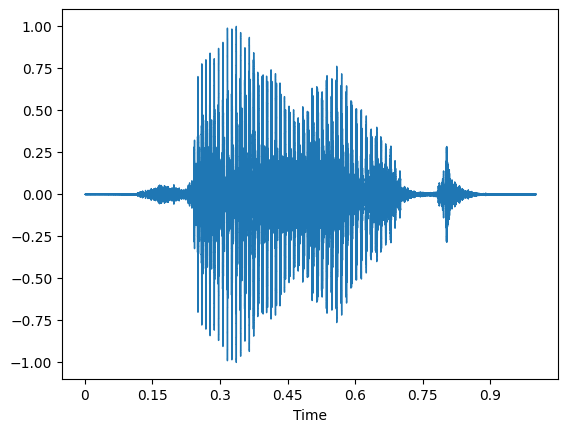

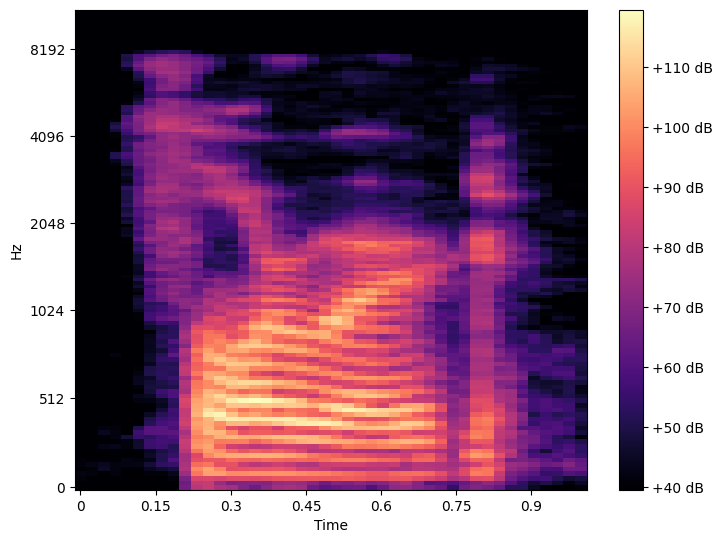

In [19]:
from team14 import AudioFile

_audio_file = '../data/audio/Speech Commands/forward/0a2b400e_nohash_0.wav'
test_audio = AudioFile(_audio_file)

test_audio.play()
test_audio.display_waveform()
test_audio.display_spectrogram()
test_audio.trim(top_db=40)

## <span style="color:red">Convert Audio Files to Spectrograms</span>

 - set input_dir and output_dir accordingly
 - call process_directory()
 - if skip_existing is True, existing spectrogram PNG files will be skipped (recommended)


___NOTE___:

- Only run this cell if you need to save out all the spectrograms. It takes awhile, and is prone to crashing (hence the use of skip_existing, so it can continue where it left off).
- Commented out the "process_directory(...)" line at the bottom to avoid accidental runs

In [ ]:
def process_directory(input_dir, skip_existing=True, include_trimmed=False):
    output_dir = os.path.join("data", "images", os.path.basename(input_dir))
    output_dir_trimmed = os.path.join(output_dir + " (trimmed)")
    for root, dirs, files in os.walk(input_dir):
        # sort directories alphabetically
        dirs.sort()
        directory = os.path.basename(root)
        print(f"Processing directory: {directory}")
        for file in files:
            if file.endswith('.wav'):
                audio = None
                # trim off .wav from file
                base, _ = os.path.splitext(file)
                output_file = os.path.join(output_dir, directory, base + ".png")
                
                if not (skip_existing and os.path.exists(output_file)):
                    # load file
                    audio = AudioFile(os.path.join(root, file))
                    # save spectrogram
                    audio.save_spectrogram(output_dir, skip_existing=skip_existing)

                if include_trimmed:
                    output_file_trimmed = os.path.join(output_dir_trimmed, directory, base + ".png")
                    if not (skip_existing and os.path.exists(output_file_trimmed)):
                        # have we loaded the file already?
                        if not audio:
                            audio = AudioFile(os.path.join(root, file))
                        # trim and save
                        audio.trim()
                        audio.save_spectrogram(output_file_trimmed, skip_existing=skip_existing)
                
process_directory('data/audio/Speech Commands_noise', skip_existing=True, include_trimmed=False)

### <span style="color:red">Corrupt image check</span>

In [ ]:
# Define your directories
output_dir = os.path.join("data", "images", "Speech Commands")
output_dir_trimmed = os.path.join("data", "images", "Speech Commands (trimmed)")

def check_png_corruption(directories, output_file="corrupt_pngs.txt"):
    corrupt_files = []
    for directory in directories:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith('.png'):
                    file_path = os.path.join(root, file)
                    try:
                        with Image.open(file_path) as img:
                            img.verify()  # This will raise an exception if the file is corrupted.
                    except Exception as e:
                        print(f"Corrupted PNG found: {file_path} (Error: {e})")
                        corrupt_files.append(file_path)

    # Write the results to a text file
    if corrupt_files:
        with open(output_file, "w") as f:
            for filename in corrupt_files:
                f.write(f"{filename}\n")
        print(f"Found {len(corrupt_files)} corrupt PNG(s). Details saved to '{output_file}'.")
    else:
        print("No corrupt PNG files found.")

# List of directories to check
directories_to_check = [output_dir, output_dir_trimmed]

# Run the check
check_png_corruption(directories_to_check)

## Convolutional Neural Net

### Setup and Parameters

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"  # Apple Metal Performance Shaders
else:
    device = "cpu"

print(f"Using {device} device")


datetime_stamp = datetime.datetime.now().strftime('%y%m%d-%H%M')

# setup tensorboard
writer_path = f"../logs/run_{datetime_stamp}"
writer = SummaryWriter(writer_path)

# path to save model
model_path = f"../models/cnn_ryan/{datetime_stamp}"
            

## PARAMETERS ##
image_size = (256, 190) # from 496x369. Closely maintains aspect ratio
num_channels = 3 # RGB images
# for DataLoader
batch_size = 64
num_workers = 2

Using mps device


### Transform and Load data 

In [6]:
from team14 import SpeechCommandsDataset

data_transforms = transforms.Compose([
    transforms.Resize((image_size[0], image_size[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# load splits from text files
with open('../docs/training_list.txt', 'r') as f:
    training_list = f.read().splitlines()

with open('../docs/validation_list.txt', 'r') as f:
    validation_list = f.read().splitlines()

with open('../docs/testing_list.txt', 'r') as f:
    testing_list = f.read().splitlines()

# set dataset root directory
data_dir = "../data/images/Speech Commands (trimmed)"

# create datasets
train_dataset = SpeechCommandsDataset(training_list, data_dir, transform=data_transforms)
val_dataset = SpeechCommandsDataset(validation_list, data_dir, transform=data_transforms)
test_dataset = SpeechCommandsDataset(testing_list, data_dir, transform=data_transforms)

# print data sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

# create data loaders
train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_batches = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_batches = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# get class labels
class_labels = train_dataset.class_to_idx
num_classes = len(class_labels)
print(f"\nClasses: {num_classes}")

Training set size: 84843
Validation set size: 9981
Testing set size: 11005

Classes: 35


#### Load Noisy Images

In [7]:
# set dataset root directory
noisy_data_dir = "../data/images/Speech Commands_noise"

# create datasets
noisy_train_dataset = SpeechCommandsDataset(training_list, noisy_data_dir, transform=data_transforms)
noisy_val_dataset = SpeechCommandsDataset(validation_list, noisy_data_dir, transform=data_transforms)
noisy_test_dataset = SpeechCommandsDataset(testing_list, noisy_data_dir, transform=data_transforms)

# print data sizes
print(f"Training set size: {len(noisy_train_dataset)}")
print(f"Validation set size: {len(noisy_val_dataset)}")
print(f"Testing set size: {len(noisy_test_dataset)}")

# create data loaders
noisy_train_batches = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
noisy_val_batches = DataLoader(noisy_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
noisy_test_batches = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Training set size: 84843
Validation set size: 9981
Testing set size: 11005


### ResNet-style Neural Net Model

In [8]:
from team14.models.ryan_resnet import ResNet, BasicBlock

# 19 layers, using BasicBlock
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
print(summary(model, input_size=(num_channels, image_size[0], image_size[1])))
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 95]             864
       BatchNorm2d-2          [-1, 32, 128, 95]              64
              ReLU-3          [-1, 32, 128, 95]               0
         ConvLayer-4          [-1, 32, 128, 95]               0
            Conv2d-5          [-1, 64, 128, 95]          18,432
       BatchNorm2d-6          [-1, 64, 128, 95]             128
              ReLU-7          [-1, 64, 128, 95]               0
         ConvLayer-8          [-1, 64, 128, 95]               0
         MaxPool2d-9           [-1, 64, 64, 48]               0
           Conv2d-10           [-1, 64, 64, 48]          36,864
      BatchNorm2d-11           [-1, 64, 64, 48]             128
           Conv2d-12           [-1, 64, 64, 48]          36,864
      BatchNorm2d-13           [-1, 64, 64, 48]             128
       BasicBlock-14           [-1, 64,

### Training Loop

In [ ]:
# display training time
def display_training_time(start, end):
    total_time = end - start
    print(f"Training time : {total_time:.3f} seconds")
    return total_time
    
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# training
def train_neural_net(epochs, model, loss_func, optimizer, train_batches, stop_patience=4, lr_scheduler=None, fine_tune=False, **val_datasets):
    final_accuracies = {}
    best_val_accuracies = {val_name: 0 for val_name in val_datasets.keys()}
    epochs_without_improvement = 0
    primary_val_name = list(val_datasets.keys())[0]   # use first validation set for early stopping

    # check if fine-tuning. if so, freeze some layers
    if fine_tune:
        trainable_params = 0
        total_params = 0
        for name, param in model.named_parameters():
            if any(layer in name for layer in ['stem', 'layer1', 'layer2']):
                param.requires_grad = False
            else:
                param.requires_grad = True
                trainable_params += param.numel()

            total_params += param.numel()
        print(f"Fine-tuning with {trainable_params:,} trainable parameters out of {total_params:,} total parameters ({100*trainable_params/total_params:.2f}%)")


    # loop over epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # === training ===
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_batches, desc="Training Batches", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            loss = loss_func(predictions, labels)
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # update learning rate here if using OneCycleLR
            if lr_scheduler and isinstance(lr_scheduler, torch.optim.lr_scheduler.OneCycleLR):
                lr_scheduler.step()
        train_loss /= len(train_batches)

        # === evaluation ===
        val_metrics = {}
        model.eval()
        with torch.inference_mode():
            for val_name, val_batches in val_datasets.items():   # there might be multiple validation sets    
                val_loss = 0
                val_accuracy = 0
                for images, labels in tqdm(val_batches, desc=f"{val_name} Batches", leave=False):
                    images = images.to(device)
                    labels = labels.to(device)
                    predictions = model(images)
                    val_loss += loss_func(predictions, labels)
                    val_accuracy += accuracy_fn(y_true=labels, y_pred=predictions.argmax(dim=1))

                val_loss /= len(val_batches)
                val_accuracy /= len(val_batches)
                val_metrics[val_name] = {"loss": val_loss, "accuracy": val_accuracy}
                final_accuracies[val_name] = val_accuracy


        # update learning rate here if using ReduceLROnPlateau
        if lr_scheduler and isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(val_metrics[primary_val_name]["loss"])

        # get current learning rate            
        learning_rate = optimizer.param_groups[0]['lr']

        # display metrics
        print(f"\nEpoch: {epoch+1} | Training loss: {train_loss:.3f} | LR: {learning_rate:.4g}")
        for val_name, metrics in val_metrics.items():
            print(f"   {val_name} loss: {metrics['loss']:.3f} | Accuracy: {metrics['accuracy']:.3f}%")

        # Log to TensorBoard
        writer.add_scalar("Loss/Training", train_loss, epoch)
        for val_name, metrics in val_metrics.items():
            writer.add_scalar(f"Loss/Validation/{val_name}", metrics["loss"], epoch)
            writer.add_scalar(f"Accuracy/Validation/{val_name}", metrics["accuracy"], epoch)
        writer.add_scalar("Learning Rate", learning_rate, epoch)

        # save checkpoint
        os.makedirs(model_path, exist_ok=True)
        torch.save(model, f"{model_path}/rn19_epoch_{epoch+1}.pt")
        print(f"Checkpoint saved at epoch {epoch+1} with val accuracy {val_accuracy:.2f}%")

        # stop training if validation accuracy has not improved for stop_patience epochs
        primary_val_accuracy = val_metrics[primary_val_name]["accuracy"]
        if primary_val_accuracy > best_val_accuracies[primary_val_name]:
            best_val_accuracies[primary_val_name] = primary_val_accuracy
            epochs_without_improvement = 0  # reset counter
        else:
            epochs_without_improvement += 1
            print(f"No improvement on {primary_val_name} for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= stop_patience:
            print(f"Early stopping: {primary_val_name} accuracy not improved for {stop_patience} epochs.")
            break

    return final_accuracies

#### <span style="color:red">Training</span>

In [ ]:
max_epochs = 30
stop_patience = 10   # if no improvement in validation accuracy for this many epochs, stop training
learning_rate = 1e-3

# parameters for OneCycleLR
max_learning_rate = 1e-1
steps_per_epoch = len(train_batches)
total_steps = max_epochs * steps_per_epoch  # total number of training steps

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_learning_rate, total_steps=total_steps)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

train_time_start_on_gpu = timer()
final_accuracies = train_neural_net(max_epochs, model, loss_func, optimizer, train_batches, stop_patience, lr_scheduler, fine_tune=False, validation=val_batches)

print(f"\nTraining complete:")
for val_name, accuracy in final_accuracies.items():
    print(f"  - {val_name} accuracy: {accuracy:.2f}%")

display_training_time(start=train_time_start_on_gpu, end=timer())

writer.flush()
writer.close()

### Metrics Graphs

In [20]:
import plotly.graph_objects as go

def plotly_metrics(losses, accuracies, learning_rate=None):

    colors = ["#82ca9d", "#ff7300", "#8884d8"]
    width = 680
    height = 420
    margins = dict(l=50, r=50, t=60, b=20)

    # ----- LOSS FIGURE -----
    fig_loss = go.Figure()
    for i, (name, csv_file) in enumerate(losses.items()):
        csv = pd.read_csv(csv_file)
        fig_loss.add_trace(go.Scatter(
            x=csv['Step']+1, y=csv['Value'], mode='lines+markers', name=name,
            line=dict(color=colors[i], width=2), hovertemplate="%{y:.3f}"
        ))

    fig_loss.update_layout(
        title_text="Training Loss", xaxis_title="Epoch", yaxis_title="Loss", hovermode="x unified",
        margin=margins,
        width=width, height=height,
        legend=dict(
            orientation="h", yanchor="top", y=-0.15, xanchor="center", x=0.5
        )
    )
    # Show Loss Figure
    fig_loss.show()

    # ----- ACCURACY FIGURE -----
    fig_acc = go.Figure()
    for i, (name, csv_file) in enumerate(accuracies.items()):
        csv = pd.read_csv(csv_file)
        fig_acc.add_trace(go.Scatter(
            x=csv['Step']+1, y=csv['Value'], mode='lines+markers', name=name,
            line=dict(color=colors[i], width=2), hovertemplate="%{y:.2f}"
        ))

    fig_acc.update_layout(
        title_text="Accuracy", xaxis_title="Epoch", yaxis_title="Loss", hovermode="x unified",
        margin=margins,
        width=width, height=height,
        legend=dict(
            orientation="h", yanchor="top", y=-0.15, xanchor="center", x=0.5
        )
    )
    # Show Loss Figure
    fig_acc.show()

    if learning_rate is not None:
        # ----- LEARNING RATE FIGURE -----
        fig_lr = go.Figure()
        csv = pd.read_csv(learning_rate)
        fig_lr.add_trace(go.Scatter(
            x=csv['Step']+1, y=csv['Value'], mode='lines+markers', name="LR",
            line=dict(color=colors[0], width=2), hovertemplate="%{y:.2e}"
        ))

        fig_lr.update_layout(
            title_text="Learning Rate", xaxis_title="Epoch", yaxis_title="Loss", hovermode="x unified",
            margin=margins,
            width=width, height=height,
            legend=dict(
                orientation="h", yanchor="top", y=-0.15, xanchor="center", x=0.5
            )
        )
        # Show Loss Figure
        fig_lr.show()


In [21]:
print("Training Metrics:")

losses = {
    "Training": "../models/cnn_ryan/250307-0336-full/csv_data/loss_train.csv",
    "Validation": "../models/cnn_ryan/250307-0336-full/csv_data/loss_validation.csv",
}
accuracies = {
    "Validation": "../models/cnn_ryan/250307-0336-full/csv_data/accuracy.csv"
}
learning_rate = "../models/cnn_ryan/250307-0336-full/csv_data/learning_rate.csv"

plotly_metrics(losses, accuracies, learning_rate)

Training Metrics:


## Inference on Test Set

In [13]:
# load a torch model
saved_model = torch.load("../models/cnn_ryan/250307-0336-full/best_model.pt", weights_only=False,  map_location=device)
saved_model.to(device)

# set the model to evaluation mode to disable dropout, etc.
saved_model.eval()

# class labels
classes = list(class_labels.keys())

all_preds = []
all_labels = []
all_filenames = []

# run inference on the test set
with torch.no_grad():
    for images, labels, filenames in tqdm(test_batches, desc="Test Batches"):
        images = images.to(device)
        predictions = saved_model(images)
        # store predictions, labels, and filenamesb
        all_preds.extend(predictions.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels)
        all_filenames.extend(filenames)

cm = confusion_matrix(all_labels, all_preds)

# calculate accuracy score
accuracy_test = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Test Accuracy: {100 * accuracy_test:0.3f}%")

# save all_preds and all_labels to csv files
np.savetxt('../models/cnn_ryan/250307-0336-full/csv_data/predictions.csv', all_preds, delimiter=',')
np.savetxt('../models/cnn_ryan/250307-0336-full/csv_data/labels.csv', all_labels, delimiter=',')

Test Batches:   0%|          | 0/172 [00:01<?, ?it/s]

Test Accuracy: 96.193%


In [22]:
# Get class index-to-name mapping
idx_to_class = {v: k for k, v in class_labels.items()}  # Reverse mapping

cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)  # Remove diagonal values (correct classifications)

# Get the top 5 most confused word pairs (sorted by value)
confused_pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm_no_diag[i, j] > 0:  # Non-diagonal misclassifications
            confused_pairs.append((i, j, cm_no_diag[i, j]))

# Sort by number of misclassifications (desc)
confused_pairs = sorted(confused_pairs, key=lambda x: x[2], reverse=True)[:6]

#### Confusion Matrix ####

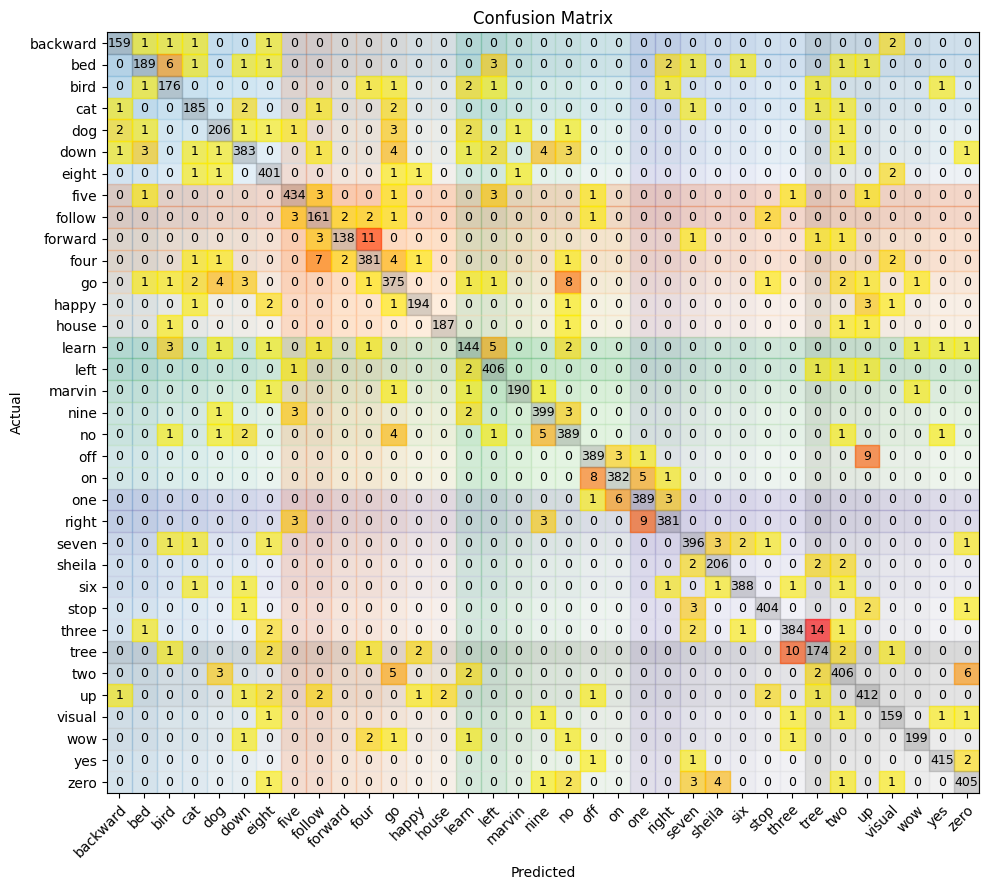

In [23]:
from team14 import NiftyConfusionMatrix

cm_plot = NiftyConfusionMatrix(cm, classes)
cm_plot.display()

### Save Confusion Matrix to CSV

In [ ]:
# cm_plot.to_csv()

## Inference on Noisy Images

In [14]:
all_preds_noisy = []
all_labels_noisy = []
all_filenames = []

# run inference on the noisy test set
with torch.no_grad():
    for images, labels, filenames in tqdm(noisy_test_batches, desc="Noisy Image Batches"):
        images = images.to(device)
        predictions = saved_model(images)
        # store predictions, labels, and filenames
        all_preds_noisy.extend(predictions.argmax(dim=1).cpu().numpy())
        all_labels_noisy.extend(labels)
        all_filenames.extend(filenames)

noisy_cm = confusion_matrix(all_labels_noisy, all_preds_noisy)

# calculate accuracy score
accuracy_noisy = np.sum(np.array(all_preds_noisy) == np.array(all_labels_noisy)) / len(all_labels_noisy)
print(f"Noisy Image Accuracy: {100 * accuracy_noisy:0.3f}%")

# save all_preds and all_labels to csv files
np.savetxt('../models/cnn_ryan/250307-0336-full/csv_data/predictions_noisy.csv', all_preds, delimiter=',')
np.savetxt('../models/cnn_ryan/250307-0336-full/csv_data/labels_noisy.csv', all_labels, delimiter=',')

Noisy Image Batches:   0%|          | 0/172 [00:02<?, ?it/s]

Noisy Image Accuracy: 75.148%


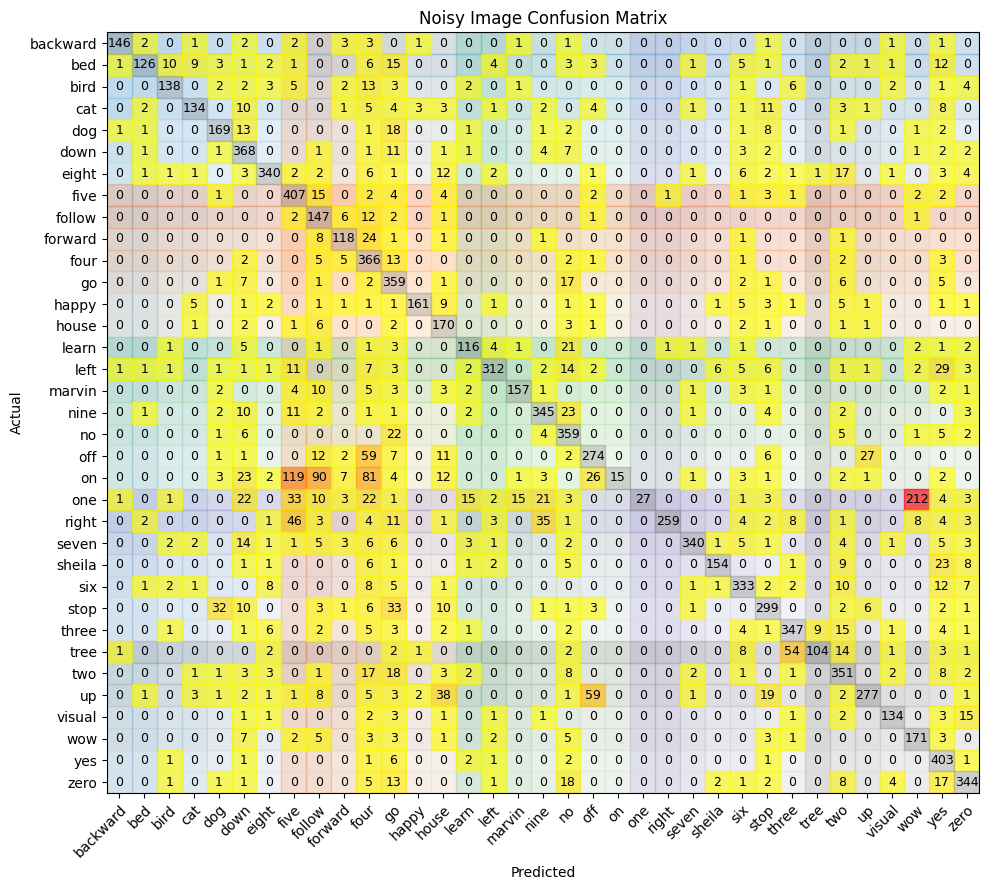

In [24]:
my_cm_plot = NiftyConfusionMatrix(noisy_cm, classes)
my_cm_plot.display(title="Noisy Image Confusion Matrix")

## <span style="color:red">Fine-Tuning on both Original and Noisy Images</span>

In [ ]:
from torch.utils.data import ConcatDataset

max_epochs = 25
stop_patience = 10   # if no improvement in validation accuracy for this many epochs, stop training
learning_rate = 1e-4    # lower loearning rate for fine-tuning

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# combine base and noisy images for fine-tuning
combined_train_dataset = ConcatDataset([train_batches.dataset, noisy_train_batches.dataset])
combined_train_batches = DataLoader(combined_train_dataset, batch_size=train_batches.batch_size, shuffle=True)

train_time_start_on_gpu = timer()
final_accuracies = train_neural_net(max_epochs, model, loss_func, optimizer, combined_train_batches, stop_patience, lr_scheduler=None, fine_tune=True, val_noisy=noisy_val_batches, val_baseline=val_batches)

print(f"\nTraining complete:")
for val_name, accuracy in final_accuracies.items():
    print(f"  - {val_name} accuracy: {accuracy:.2f}%")

display_training_time(start=train_time_start_on_gpu, end=timer())

writer.flush()
writer.close()

### Fine-Tuning Metrics - Plotly Graphs

In [25]:
print("Fine-Tuning Metrics:")

losses = {
    "Training": "../models/cnn_ryan/250312-finetune-full/csv_data/loss_train.csv",
    "Baseline Validation": "../models/cnn_ryan/250312-finetune-full/csv_data/loss_val_baseline.csv",
    "Noisy Validation": "../models/cnn_ryan/250312-finetune-full/csv_data/loss_val_noisy.csv"
}
accuracies = {
    "Baseline Validation": "../models/cnn_ryan/250312-finetune-full/csv_data/val_baseline.csv",
    "Noisy Validation": "../models/cnn_ryan/250312-finetune-full/csv_data/val_noisy.csv"
}

plotly_metrics(losses, accuracies)

Fine-Tuning Metrics:


### Evaluation after fine-tuning on Original and Noisy Images


In [26]:
# load a torch model
model_finetune_full = torch.load("../models/cnn_ryan/250312-finetune-full/best_model.pt", weights_only=False, map_location=device)
model_finetune_full.to(device)
model_finetune_full.eval()
classes = list(class_labels.keys())

#### Original Images

In [16]:
all_preds = []
all_labels = []
all_filenames = []

# run inference on the test set
with torch.no_grad():
    for images, labels, filenames in tqdm(test_batches, desc="Test Batches"):
        images = images.to(device)
        predictions = model_finetune_full(images)
        # store predictions, labels, and filenames
        all_preds.extend(predictions.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels)
        all_filenames.extend(filenames)

cm_finetune_full_baseline = confusion_matrix(all_labels, all_preds)

# calculate accuracy score
accuracy_test = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Test Accuracy (original images): {100 * accuracy_test:0.3f}%")

# save all_preds and all_labels to csv files
np.savetxt('../models/cnn_ryan/250312-finetune-full/csv_data/predictions.csv', all_preds, delimiter=',')
np.savetxt('../models/cnn_ryan/250312-finetune-full/csv_data/labels.csv', all_labels, delimiter=',')

Test Batches:   0%|          | 0/172 [00:02<?, ?it/s]

Test Accuracy (original images): 93.476%


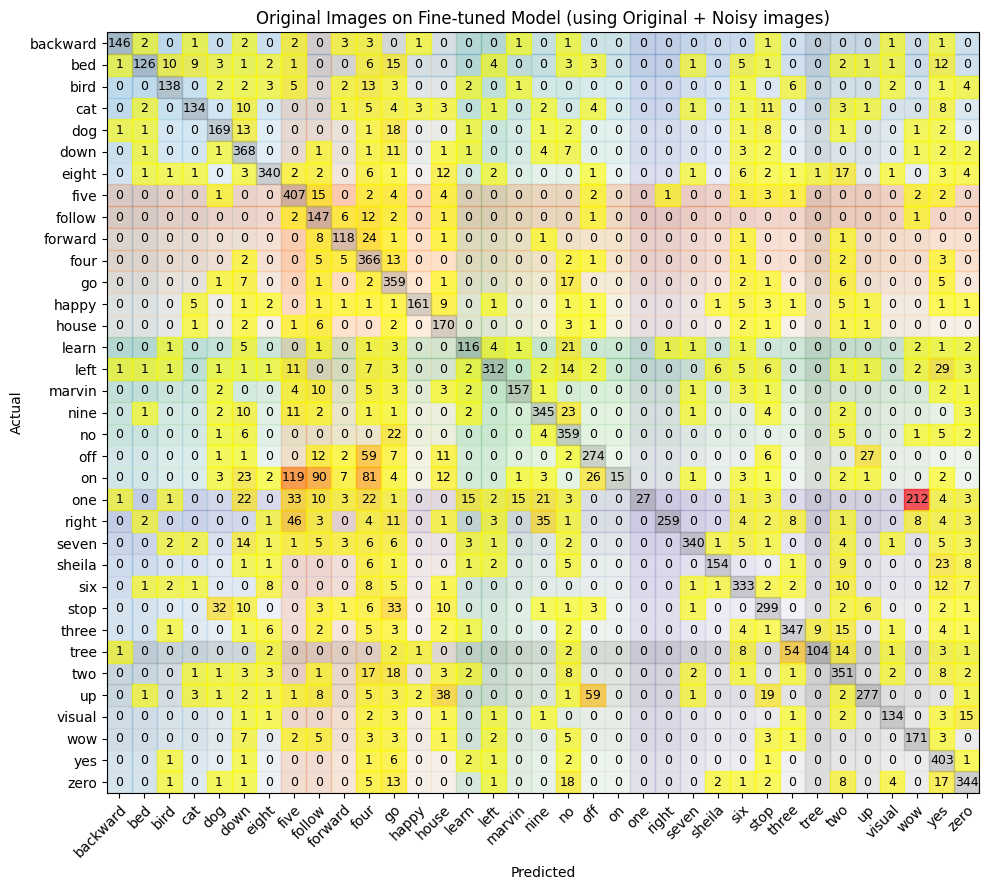

In [27]:
my_cm_plot = NiftyConfusionMatrix(noisy_cm, classes)
my_cm_plot.display(title="Original Images on Fine-tuned Model (using Original + Noisy images)")

#### Noisy Images

In [ ]:
all_preds = []
all_labels = []
all_filenames = []

# run inference on the noisy test set
with torch.no_grad():
    for images, labels, filenames in tqdm(noisy_test_batches, desc="Noisy Image Batches"):
        images = images.to(device)
        predictions = saved_model(images)
        # store predictions, labels, and filenames
        all_preds_noisy.extend(predictions.argmax(dim=1).cpu().numpy())
        all_labels_noisy.extend(labels)
        all_filenames.extend(filenames)

cm_finetune_full_noisy = confusion_matrix(all_labels, all_preds)

# calculate accuracy score
accuracy_test = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Test Accuracy (noisy images): {100 * accuracy_test:0.3f}%")

# save all_preds and all_labels to csv files
np.savetxt('../models/cnn_ryan/250312-finetune-full/csv_data/predictions_noisy.csv', all_preds, delimiter=',')
np.savetxt('../models/cnn_ryan/250312-finetune-full/csv_data/labels_noisy.csv', all_labels, delimiter=',')

Noisy Image Batches:   0%|          | 0/172 [00:02<?, ?it/s]

Test Accuracy (noisy images): nan%


/var/folders/4j/y3g4dtnj7mdfz4f2dys11zwh0000gn/T/ipykernel_9861/2041947254.py:18: RuntimeWarning:

invalid value encountered in long_scalars



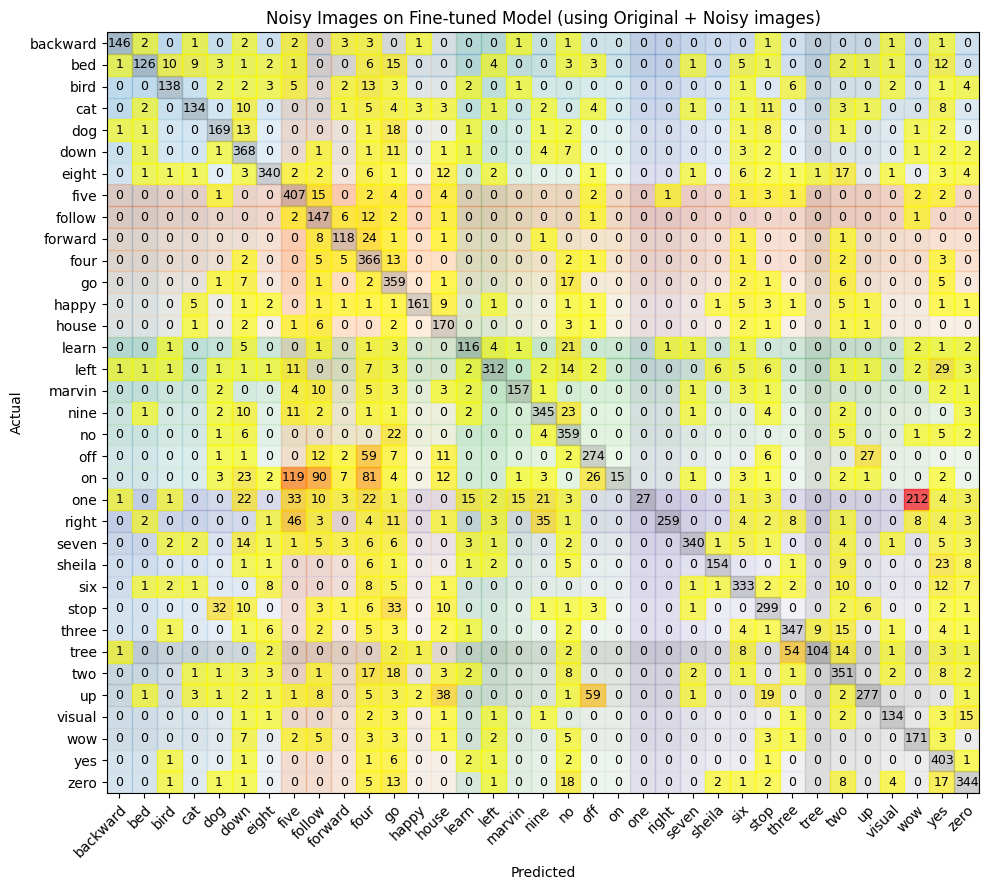

In [29]:
my_cm_plot = NiftyConfusionMatrix(noisy_cm, classes)
my_cm_plot.display(title="Noisy Images on Fine-tuned Model (using Original + Noisy images)")